
## Exercise instruction

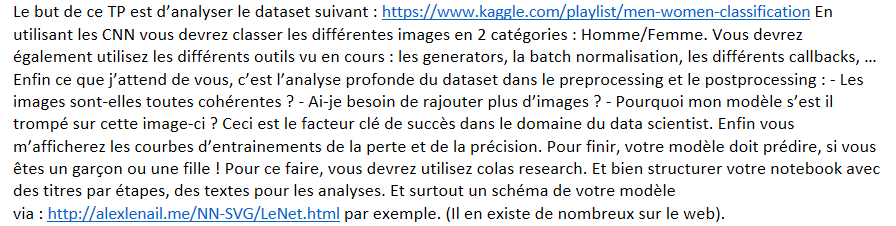

## Import Library

In [0]:
from contextlib import contextmanager
import os
import sys

In [3]:
import tensorflow as tf
import numpy as np
import cv2
import math
import pathlib
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from matplotlib import pyplot as plt

Using TensorFlow backend.


Dataset : https://www.kaggle.com/playlist/men-women-classification

In [0]:
@contextmanager
def suppress_stdout():
  with open(os.devnull, "w") as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:  
        yield
    finally:
      sys.stdout = old_stdout

In [0]:
file = open('/content/kaggle.json', 'w')
file.write('{"username":"pietrinicolas","key":"dd6c8cd0e5a0036dea1dabaaf8f1daee"}')
file.close()

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d playlist/men-women-classification

kaggle.json
 99% 1.17G/1.19G [00:18<00:00, 63.2MB/s]
100% 1.19G/1.19G [00:18<00:00, 68.2MB/s]


In [6]:
print("Unzipping files...")
with suppress_stdout():
  !unzip men-women-classification.zip
print("Files unzipped")

Unzipping files...
Files unzipped


In [0]:
# mkdir ppl

In [0]:
# mkdir ppl/m

In [0]:
# ls -Q /content/men | head -3 | xargs -i mv /content/men/{} /content/ppl/m/

In [0]:
! mkdir people
! mv /content/men /content/people/
! mv /content/women /content/people/

In [8]:
filenames = os.listdir("/content/people/")
print(filenames)

['women', 'men']


## Prepare Traning Data

In [0]:
img_size = 150

#===# creating dataset
def load_imgs_and_labels(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping horizontally
# resizing
# rescaling

def process_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img/255
    
  except Exception as e:
    pass

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "men": 0,
      "women": 1
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "man",
      1: "woman"
  }
  return labels.get(int_label)

In [0]:
data_dir = pathlib.Path('people')
file_paths = np.array(list(data_dir.glob('*/*.jpg')))

In [50]:
np.random.shuffle(file_paths)
datas = load_imgs_and_labels(file_paths)

500/2994
1000/2994
1500/2994
2000/2994
2500/2994


In [0]:
dataset = datas[0]
labels = datas[1]

In [52]:
import pandas as pd 
df = pd.DataFrame({
    'filename': dataset,
    'category': labels
})

df.head()
df.tail()

,filename,category
2989,"[[[0.9098039215686274, 0.9098039215686274, 0.9...",1
2990,"[[[0.11372549019607843, 0.2196078431372549, 0....",1
2991,"[[[0.9294117647058824, 0.9254901960784314, 0.9...",1
2992,"[[[0.9294117647058824, 0.9215686274509803, 0.8...",1
2993,"[[[0.9294117647058824, 0.9176470588235294, 0.9...",0


In [53]:
df.head()

,filename,category
0,"[[[0.7843137254901961, 0.792156862745098, 0.80...",0
1,"[[[0.07450980392156863, 0.10196078431372549, 0...",1
2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
3,"[[[0.984313725490196, 0.984313725490196, 0.984...",0
4,"[[[0.6745098039215687, 0.6666666666666666, 0.6...",0


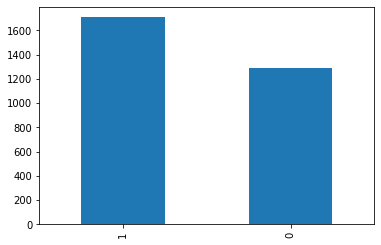

In [54]:
df['category'].value_counts().plot.bar()

From our data we have about 1600 men and 1200 women

In [0]:
DS_SIZE = len(datas[0])
TEST_SIZE = math.ceil(DS_SIZE *0.2)

train_data = dataset[0:-TEST_SIZE]
train_labels = labels[0:-TEST_SIZE]

test_data = dataset[-TEST_SIZE:]
test_labels = labels[-TEST_SIZE:]

In [0]:
# save data after first run
np.save('test_data', test_data)
np.save('train_data', train_data)
np.save('test_labels', test_labels)
np.save('train_labels', train_labels)

In [0]:
# restore data after crash
test_data = np.load('test_data.npy')
train_data = np.load('train_data.npy')

test_labels = np.load('test_labels.npy')
train_labels = np.load('train_labels.npy')

## See sample image

woman


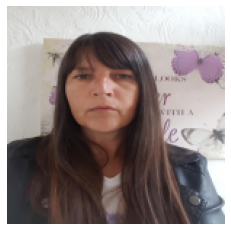

In [9]:
print(translate_label_from_int_to_str(train_labels[150]))
plt.imshow(cv2.cvtColor(train_data[150].astype('float32'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = training_ceiling()

epochs=150
batch_size=128

model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation= tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(128, activation= tf.nn.relu),
    # tf.keras.layers.Dense(64, activation= tf.nn.relu),

    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.summary()

from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.2, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.1,
        )
data_generator.fit(np.asarray(train_data))

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    data_generator.flow(
        np.asarray(train_data),
        np.asarray(train_labels), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(test_data),
                     np.asarray(test_labels)),
    verbose = 1, 
    steps_per_epoch=np.asarray(train_data).shape[0] // batch_size,
    callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [0]:
#==# stopping the model from overfitting (when validation loss starts to rise)
# class training_ceiling(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.9999):
#       print("\nReached 99.99% accuracy so cancelling training!")
#       self.model.stop_training = True

In [0]:
# epochs=100
# batch_size=100

In [0]:
# callbacks = training_ceiling()

In [0]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size , img_size , 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax')) # 2 because we have men and women

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [0]:
# model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
#               loss = 'sparse_categorical_crossentropy',
#               metrics=['accuracy'])

## Fit Model

In [0]:
# history = model.fit(
#     np.asarray(train_data), 
#     np.asarray(train_labels), 
#     validation_data=(np.asarray(test_data),np.asarray(test_labels)), 
#     epochs=epochs, 
#     batch_size=batch_size, 
#     callbacks=[callbacks])

In [11]:
model.evaluate(np.asarray(test_data), np.asarray(test_labels))

19/19 [==============================] - 0s 9ms/step - loss: 0.4544 - accuracy: 0.8013


[0.4543793201446533, 0.8013355731964111]

## Save Model

In [0]:
model.save_weights("model.h5")

## Virtualize Training

NameError: ignored

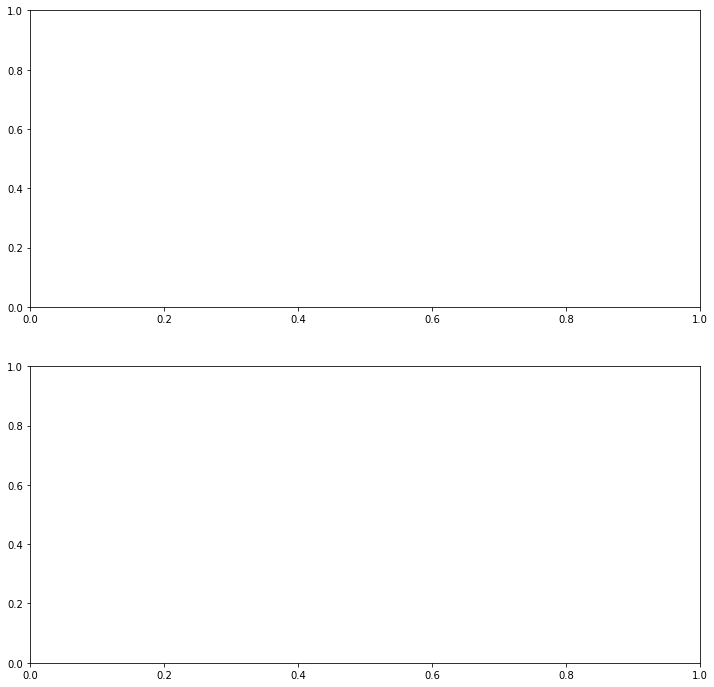

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## See predicted result with images

In [0]:
predictions = model.predict_classes(testData)

In [0]:

import random


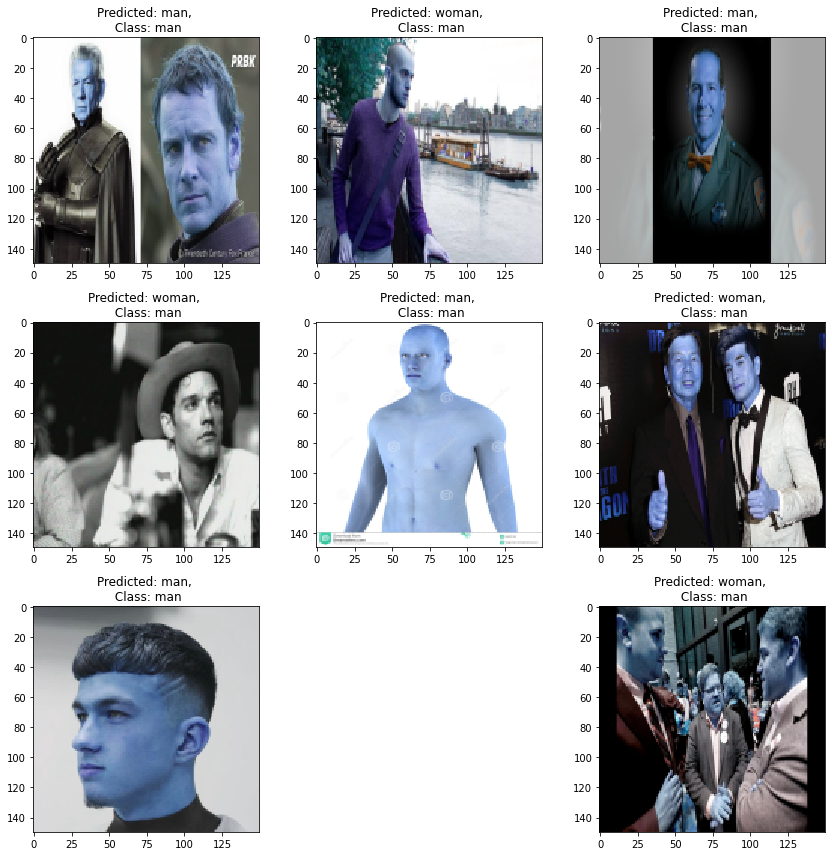

In [31]:
random_indices = [random.randint(1, 599) for i in range(9)]

plt.figure(figsize=(12,12))
for i, index in enumerate(random_indices):
    pred = predictions[index]
    pred = 'man' if pred==0 else 'woman'
    actual = 'man' if testLabel[index]==0 else 'woman'
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[index], cmap='gray', interpolation='none')
    plt.title(f"Predicted: {pred}, \n Class: {actual}")
    plt.tight_layout()